# CNN com CIFAR-10

## Dados + Teoria

In [31]:
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### Leitura Inicial do Dados

In [32]:
# Função para carregar os dados do CIFAR-10 (do website)
def unpickle(file):
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [33]:
CIFAR_DIR = Path("..") / "data" / "cifar-10-batches-py" 

TRAIN_BATCHES = [f"data_batch_{i}" for i in range(1, 6)]
TEST_BATCH = "test_batch"
META_FILE = "batches.meta"


def ensure_exists(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {p}\n"
                                f"Verifique o caminho ou baixe o CIFAR-10 (python version).")



#### Conjuntos de Treinamento e Teste

In [34]:
def load_cifar10_numpy(cifar_dir: Path):
    """
    Retorna:
      X_train: (50000, 3, 32, 32) uint8
      y_train: (50000,) int
      X_test : (10000,  3, 32, 32) uint8
      y_test : (10000,) int
      classes: list[str] com 10 nomes
    """
    # Meta
    meta_path = cifar_dir / META_FILE
    ensure_exists(meta_path)
    meta = unpickle(meta_path)
    classes = [c.decode("utf-8") for c in meta[b"label_names"]]

    # Train
    X_train_chunks = []
    y_train_chunks = []
    for fname in TRAIN_BATCHES:
        fpath = cifar_dir / fname
        ensure_exists(fpath)
        obj = unpickle(fpath)  # dict com chaves b'data', b'labels'
        data = obj[b"data"]  # (10000, 3072) uint8
        labels = np.array(obj[b"labels"], dtype=np.int64)  # (10000,)

        # reshape para (N, 3, 32, 32)
        # Formato original: cada linha = [R(1024), G(1024), B(1024)]
        data = data.reshape(-1, 3, 32, 32)
        X_train_chunks.append(data)
        y_train_chunks.append(labels)

    X_train = np.concatenate(X_train_chunks, axis=0)
    y_train = np.concatenate(y_train_chunks, axis=0)

    # Test
    test_path = cifar_dir / TEST_BATCH
    ensure_exists(test_path)
    obj_test = unpickle(test_path)
    X_test = obj_test[b"data"].reshape(-1, 3, 32, 32)
    y_test = np.array(obj_test[b"labels"], dtype=np.int64)

    # sanity checks
    assert X_train.shape == (50000, 3, 32, 32)
    assert X_test.shape  == (10000,  3, 32, 32)
    assert y_train.shape == (50000,)
    assert y_test.shape  == (10000,)

    return X_train, y_train, X_test, y_test, classes


In [35]:
X_train, y_train, X_test, y_test, classes = load_cifar10_numpy(CIFAR_DIR)

print("Classes:", classes)
print(f"\nX_train: {X_train.shape}, {X_train.dtype}")
print(f"y_train: {y_train.shape}, {y_train.dtype}")
print(f"X_test : {X_test.shape}, {X_test.dtype}")
print(f"y_test : {y_test.shape}, {y_test.dtype}")


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

X_train: (50000, 3, 32, 32), uint8
y_train: (50000,), int64
X_test : (10000, 3, 32, 32), uint8
y_test : (10000,), int64


#### Exibindo estrutura do dado como sinais 1D/2D/3D

In [36]:
# =========================
def as_1d_vector(img_chw: np.ndarray) -> np.ndarray:
    """
    img_chw: (3, 32, 32) uint8
    retorno: (3072,) uint8
    """
    return img_chw.reshape(-1)

# =========================
def as_2d_grayscale(img_chw: np.ndarray, method: str = "luminosity") -> np.ndarray:
    """
    Converte RGB -> cinza (32x32) usando:
      - 'avg'          : média simples
      - 'luminosity'   : 0.299*R + 0.587*G + 0.114*B (padrão)
    Retorno: (32, 32) float32 na faixa [0,255]
    """
    r, g, b = img_chw[0].astype(np.float32), img_chw[1].astype(np.float32), img_chw[2].astype(np.float32)
    if method == "avg":
        gray = (r + g + b) / 3.0
    else:
        gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray

# =========================
def as_3d_rgb(img_chw: np.ndarray) -> np.ndarray:
    """
    Converte (3,32,32) -> (32,32,3) para exibição no matplotlib.
    """
    return np.transpose(img_chw, (1, 2, 0))


In [37]:
# =========================
def show_sample_views(X: np.ndarray, y: np.ndarray, classes: list[str], idx: int = 0):
    """
    Mostra o mesmo exemplo como:
      - Vetor 1D (exibe só um "trecho" do vetor para visualização)
      - Imagem 2D em escala de cinza
      - Tensor RGB (3D) como imagem colorida
    """
    img = X[idx]              # (3,32,32)
    label_idx = int(y[idx])
    label = classes[label_idx]

    vec_1d = as_1d_vector(img)
    gray_2d = as_2d_grayscale(img)
    rgb_3d = as_3d_rgb(img)

    print(f"Índice: {idx} | Classe: {label} ({label_idx})")
    print(f"Formas -> 1D: {vec_1d.shape},\n        2D: {gray_2d.shape},\n       3D: {rgb_3d.shape}")
    print(f"\nPrimeiros 20 elementos do vetor 1D: {vec_1d[:20]}")

    # Plotagens simples
    plt.figure(figsize=(12, 3))

    # 1D: mostramos um "sinal" com os primeiros 200 valores do vetor
    plt.subplot(1, 3, 1)
    plt.plot(vec_1d[:200])
    plt.title("1D (primeiros 200 valores)")
    plt.xlabel("índice")
    plt.ylabel("intensidade")

    # 2D: grayscale
    plt.subplot(1, 3, 2)
    plt.imshow(gray_2d, cmap="gray", vmin=0, vmax=255)
    plt.title("2D (grayscale)")
    plt.axis("off")

    # 3D: RGB
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_3d)
    plt.title("3D (RGB)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Índice: 0 | Classe: frog (6)
Formas -> 1D: (3072,),
        2D: (32, 32),
       3D: (32, 32, 3)

Primeiros 20 elementos do vetor 1D: [ 59  43  50  68  98 119 139 145 149 149 131 125 142 144 137 129 137 134
 124 139]


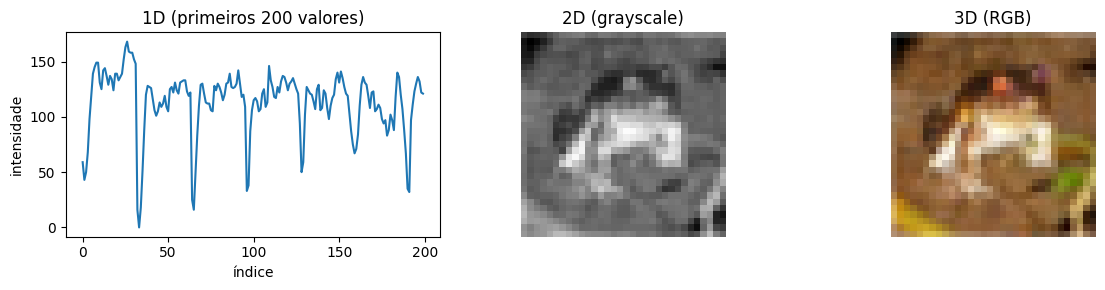

In [38]:
show_sample_views(X_train, y_train, classes, idx=0)

#### Estatísticas por canal (média/desvio) para normalização

Calculadas apenas no treino. Em escala [0,1] (compatível com ToTensor() do torchvision).


In [39]:
import numpy as np

def compute_channel_stats_01(X_train_chw_uint8: np.ndarray):
    """
    X_train: (N, 3, 32, 32) uint8
    Retorna mean,std por canal (em [0,1]) como listas de floats para usar no Normalize.
    """
    X = X_train_chw_uint8.astype(np.float32) / 255.0   # [0,1]
    # eixo 0=N, 2=H, 3=W -> média por canal
    mean = X.mean(axis=(0, 2, 3)).tolist()            # len=3
    std  = X.std(axis=(0, 2, 3), ddof=0).tolist()     # len=3
    return mean, std

# Exemplo de uso:
X_train, y_train, X_test, y_test, classes = load_cifar10_numpy(CIFAR_DIR)
mean, std = compute_channel_stats_01(X_train)
print("mean:", mean, "std:", std)


mean: [0.49140089750289917, 0.48215895891189575, 0.4465307891368866] std: [0.2470327913761139, 0.243484228849411, 0.261587530374527]


#### Correlação não-normalizada (1D) + zero padding

In [40]:
def zero_pad_1d(x: np.ndarray, pad_left: int, pad_right: int):
    """
    Retorna [0...0, x, 0...0] com zeros anexados à esquerda e à direita.
    """
    assert pad_left >= 0 and pad_right >= 0
    if pad_left == 0 and pad_right == 0:
        return x
    return np.pad(x, (pad_left, pad_right), mode='constant', constant_values=0)

def xcorr_unnormalized(s: np.ndarray, g: np.ndarray):
    """
    Correlação não-normalizada r_sg = correlate(s, g) (definição 's * g' sem normalização).
    Implementada via convolução com g invertido, 'full' para cobrir todos os deslocamentos.
    r tem tamanho len(s)+len(g)-1.
    """
    s = np.asarray(s, dtype=np.float64)
    g = np.asarray(g, dtype=np.float64)
    if len(g) >= len(s):
        raise ValueError(f"O sinal g deve ter dimensão estritamente menor que s. len(g)={len(g)} >= len(s)={len(s)}")
    r = np.convolve(s, g[::-1], mode='full')
    return r

def demo_xcorr_from_cifar_channel(X_train: np.ndarray, idx_img: int = 0, channel: int = 0,
                                  g: np.ndarray | None = None, pad_left: int = 0, pad_right: int = 0):
    """
    Exemplo didático:
      - Extrai um canal (32x32) da img idx_img do treino.
      - Achata em 1D (s).
      - (Opcional) faz zero padding em s.
      - Correla s com g (definido ou gerado).
    Retorna: s, s_padded, g, r
    """
    img_chw = X_train[idx_img].astype(np.float64)  # (3,32,32)
    s = img_chw[channel].reshape(-1)               # (1024,) -> 1D
    if g is None:
        # kernel curto de exemplo (qualquer vetor 1D mais curto que s serve)
        g = np.array([1, -1, 2, 0, -2, 1], dtype=np.float64)

    # zero padding
    s_pad = zero_pad_1d(s, pad_left, pad_right)

    # correlação não-normalizada
    r = xcorr_unnormalized(s_pad, g)
    # Verificações
    # len(r) = len(s_pad) + len(g) - 1
    assert len(r) == len(s_pad) + len(g) - 1

    return s, s_pad, g, r

# Exemplo rápido:
s, s_pad, g, r = demo_xcorr_from_cifar_channel(X_train, idx_img=0, channel=0, pad_left=10, pad_right=10)
print(len(s), len(s_pad), len(g), len(r))  # 1024, 1044, 6, 1049


1024 1044 6 1049


## Validação e DataLoaders

#### Split estratificado treino/val (45k/5k)

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_train_val_split(X: np.ndarray, y: np.ndarray, val_size: int = 5000, random_state: int = 42):
    """
    X: (50000, 3, 32, 32) ; y: (50000,)
    val_size: número absoluto de amostras de validação (ex: 5000)
    Retorna índices: idx_train, idx_val
    """
    assert len(X) == 50000 and len(y) == 50000, "Esperado conjunto de treino original (50k)."
    test_size = val_size / len(X)
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    idx_train, idx_val = next(splitter.split(X, y))
    return idx_train, idx_val

# Exemplo:
idx_train, idx_val = stratified_train_val_split(X_train, y_train, val_size=5000)
print(f"Train: {len(idx_train)}, Val: {len(idx_val)}")  # 45000, 5000


Train: 45000, Val: 5000


#### DataLoaders com transforms e workers

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import os

class CIFARNumpyDataset(Dataset):
    """
    Dataset simples que recebe arrays numpy (CHW uint8) e aplica transforms do torchvision.
    """
    def __init__(self, X_chw_uint8: np.ndarray, y: np.ndarray, transform=None):
        self.X = X_chw_uint8
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        img = self.X[i]                 # (3, 32, 32) uint8
        label = int(self.y[i])
        # ToTensor espera HWC | vamos converter CHW->HWC
        img_hwc = np.transpose(img, (1, 2, 0))  # (32,32,3)
        if self.transform is not None:
            # transforms do torchvision assumem PIL.Image ou ndarray HxWxC
            img_t = self.transform(img_hwc)
        else:
            # fallback: tensor bruto [0,1]
            img_t = torch.from_numpy(img / 255.0).float()
        return img_t, label

def make_transforms(mean, std):
    tf_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                 # [0,1]
        transforms.Normalize(mean, std),
    ])
    tf_eval = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return tf_train, tf_eval

def make_dataloaders(X_train, y_train, X_test, y_test, idx_train, idx_val,
                     mean, std, batch_size=128, num_workers=None):
    """
    Cria DataLoaders para train/val/test com configs pedidas.
    """
    if num_workers is None:
        # escolha segura; ajuste conforme sua máquina
        num_workers = 0 if os.name == "nt" else 2 
    import os

    tf_train, tf_eval = make_transforms(mean, std)

    ds_full_train = CIFARNumpyDataset(X_train, y_train, transform=tf_train)
    ds_val        = CIFARNumpyDataset(X_train, y_train, transform=tf_eval)
    ds_test       = CIFARNumpyDataset(X_test,  y_test,  transform=tf_eval)

    ds_train = Subset(ds_full_train, indices=idx_train)
    ds_val   = Subset(ds_val,        indices=idx_val)

    # pin_memory é útil se você treinar em GPU
    pin = torch.cuda.is_available()

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin, drop_last=False)
    dl_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin, drop_last=False)
    dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin, drop_last=False)
    return dl_train, dl_val, dl_test

# ===== Uso
# dl_train, dl_val, dl_test = make_dataloaders(X_train, y_train, X_test, y_test, idx_train, idx_val, mean, std,batch_size=128, num_workers=4)

# # inspeção rápida
# xb, yb = next(iter(dl_train))
# print(xb.shape, yb.shape)  # torch.Size([128, 3, 32, 32]) torch.Size([128])

## Arquitetura da Rede

In [43]:
# ===== cnn_cifar10.py =====
from __future__ import annotations
import os, math, random, time
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset

# (opcional) para o relatório e a matriz de confusão
from sklearn.metrics import confusion_matrix


In [44]:
# ------------------------------------------------------------
# 0) Determinismo, device e utilidades
# ------------------------------------------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # determinismo do cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def top1_accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    pred = logits.argmax(dim=1)
    return (pred == targets).float().mean().item()

In [45]:
# ------------------------------------------------------------
# 1) Blocos da rede
# ------------------------------------------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k: int = 3, s: int = 1, p: str | int = "same"):
        super().__init__()
        if p == "same":
            # padding "mesmo tamanho" para k ímpar
            p = k // 2
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    """
    Dois Conv(3x3) com BN+ReLU + atalho (1x1) se canais mudarem.
    MaxPool(2x2) é aplicado FORA do bloco (no Stage) para manter o atalho estável.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch, out_ch, k=3, s=1, p="same")
        self.conv2 = ConvBNReLU(out_ch, out_ch, k=3, s=1, p="same")
        self.need_proj = (in_ch != out_ch)
        self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False) if self.need_proj else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.need_proj:
            identity = self.proj(identity)
        out = out + identity
        return out

class Stage(nn.Module):
    """
    Stage = ResidualBlock(in->out)  -> MaxPool(2x2)
    """
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.block = ResidualBlock(in_ch, out_ch)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block(x)
        x = self.pool(x)
        return x

class SobelStem(nn.Module):
    def __init__(self):
        super().__init__()
        kx = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]], dtype=torch.float32)
        ky = torch.tensor([[1,  2,  1],
                           [0,  0,  0],
                           [-1, -2, -1]], dtype=torch.float32)

        # buffers já no shape certo (3,1,3,3)
        self.register_buffer("kx3", kx.view(1,1,3,3).repeat(3,1,1,1))
        self.register_buffer("ky3", ky.view(1,1,3,3).repeat(3,1,1,1))

        self.dw_kx = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3, bias=False)
        self.dw_ky = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3, bias=False)
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x: torch.Tensor):
        with torch.no_grad():
            self.dw_kx.weight.copy_(self.kx3)  # (3,1,3,3)
            self.dw_ky.weight.copy_(self.ky3)
        gx = self.dw_kx(x)
        gy = self.dw_ky(x)
        mag = torch.sqrt(gx * gx + gy * gy + 1e-6)
        return torch.cat([x, mag], dim=1)  # [B, 6, H, W]


class CifarCNN(nn.Module):
    def __init__(self, num_classes: int = 10, use_sobel: bool = False, base_channels: int = 64):
        super().__init__()
        in_ch = 3
        self.use_sobel = use_sobel
        if use_sobel:
            self.sobel = SobelStem()
            in_ch = 6
        else:
            self.sobel = nn.Identity()

        # Stem conv para ajustar canais de entrada
        self.stem = ConvBNReLU(in_ch, base_channels, k=3, s=1, p="same")
        # Três estágios com downsampling via MaxPool
        self.stage1 = Stage(base_channels,   base_channels)        # 32 -> 16
        self.stage2 = Stage(base_channels,   base_channels * 2)    # 16 -> 8
        self.stage3 = Stage(base_channels*2, base_channels * 4)    # 8  -> 4

        self.head = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),   # [B, C, 1, 1]
        )
        self.fc = nn.Linear(base_channels*4, num_classes)

        # init kaiming
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.sobel(x)       # [B, 3] -> [B, 6] se ativado
        x = self.stem(x)        # [B, C]
        x = self.stage1(x)      # 32→16
        x = self.stage2(x)      # 16→8
        x = self.stage3(x)      # 8→4
        x = self.head(x)
        x = torch.flatten(x, 1) # [B, C]
        x = self.fc(x)
        return x


In [46]:
# ------------------------------------------------------------
# 2) Treino / Validação / Teste
# ------------------------------------------------------------
@dataclass
class TrainCfg:
    epochs: int = 30
    batch_size: int = 128
    lr: float = 0.1
    momentum: float = 0.9
    weight_decay: float = 5e-4
    grad_clip: float = 1.0
    use_sobel: bool = False
    base_channels: int = 64
    out_dir: str = "checkpoints"
    seed: int = 42
    # cosine annealing
    eta_min: float = 0.0

def train_one_epoch(model, loader: DataLoader, optimizer, scheduler, device, grad_clip=1.0):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()

        if grad_clip is not None and grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        # scheduler por passo
        if scheduler is not None:
            scheduler.step()

        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_acc  += (logits.argmax(1) == yb).float().sum().item()
        n += bs

    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader: DataLoader, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_acc  += (logits.argmax(1) == yb).float().sum().item()
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def test_report(model, loader: DataLoader, device, class_names: List[str]):
    model.eval()
    all_preds, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy().tolist()
        all_preds   += preds
        all_targets += yb.numpy().tolist()

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(class_names))))
    acc_global = (all_preds == all_targets).mean()

    # acurácia por classe
    per_class_acc = {}
    for i, name in enumerate(class_names):
        mask = (all_targets == i)
        correct = (all_preds[mask] == i).sum()
        total = mask.sum()
        per_class_acc[name] = (correct / total) if total > 0 else float("nan")

    return acc_global, cm, per_class_acc

In [47]:
# ------------------------------------------------------------
# 3) Runner principal (integra com DataLoaders prontos)
# ------------------------------------------------------------
def run_training(dl_train, dl_val, dl_test, class_names, cfg: TrainCfg):
    set_seed(cfg.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("== Config ==", cfg); print("Device:", device)
    assert len(dl_train)>0 and len(dl_val)>0 and len(dl_test)>0, "Algum DataLoader está vazio!"

    model = CifarCNN(num_classes=len(class_names),
                     use_sobel=cfg.use_sobel,
                     base_channels=cfg.base_channels).to(device)
    print("Modelo:", model.__class__.__name__)

    optimizer = SGD(model.parameters(),
                    lr=cfg.lr,
                    momentum=cfg.momentum,
                    weight_decay=cfg.weight_decay)

    total_steps = cfg.epochs * len(dl_train)
    assert total_steps>0, "total_steps==0 (dl_train vazio?)"
    scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=cfg.eta_min)

    best_acc = -1.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    for epoch in range(1, cfg.epochs+1):
        tr_l, tr_a = train_one_epoch(model, dl_train, optimizer, scheduler, device, grad_clip=cfg.grad_clip)
        va_l, va_a = evaluate(model, dl_val, device)

        history["train_loss"].append(tr_l)
        history["train_acc"].append(tr_a)
        history["val_loss"].append(va_l)
        history["val_acc"].append(va_a)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        print(f"[{epoch:03d}/{cfg.epochs}] train_loss={tr_l:.4f} acc={tr_a*100:5.2f}% | "
              f"val_loss={va_l:.4f} acc={va_a*100:5.2f}% | lr={optimizer.param_groups[0]['lr']:.5f}")

        if va_a > best_acc:
            best_acc = va_a
            torch.save({"model": model.state_dict(),
                        "epoch": epoch,
                        "val_acc": best_acc}, "best.pt")

    print("Treino concluído. Carregando melhor checkpoint...")
    ckpt = torch.load("best.pt", map_location=device)
    model.load_state_dict(ckpt["model"])

    acc, cm, per_class = test_report(model, dl_test, device, class_names)
    report = {"acc_global": float(acc), "cm": cm, "per_class_acc": per_class}

    print("\n== TESTE ==")
    print(f"Acurácia global: {acc*100:.2f}%")
    print("Acurácia por classe:")
    for k,v in per_class.items():
        print(f"  {k:>10s}: {v*100:5.2f}%")
    print("\nMatriz de confusão:\n", cm)

    return model, history, report


In [48]:
def main():
    # X_train, y_train, X_test, y_test, classes = load_cifar10_numpy(CIFAR_DIR)
    #  mean, std = compute_channel_stats_01(X_train)
    # idx_train, idx_val = stratified_train_val_split(X_train, y_train, val_size=5000)

    dl_train, dl_val, dl_test = make_dataloaders(
        X_train, y_train, X_test, y_test, idx_train, idx_val,
        mean, std,
        batch_size=128,
        num_workers=0 # comece com 0 no Windows
    )

    # from cnn_cifar10 import TrainCfg, run_training
    cfg = TrainCfg(epochs=2, use_sobel=False, base_channels=64, lr=0.1)
    model, history, report = run_training(dl_train, dl_val, dl_test, classes, cfg)

if __name__ == "__main__":
    main()


== Config == TrainCfg(epochs=2, batch_size=128, lr=0.1, momentum=0.9, weight_decay=0.0005, grad_clip=1.0, use_sobel=False, base_channels=64, out_dir='checkpoints', seed=42, eta_min=0.0)
Device: cpu
Modelo: CifarCNN
[001/2] train_loss=1.3243 acc=51.40% | val_loss=1.0102 acc=64.20% | lr=0.05000
[002/2] train_loss=0.8265 acc=70.90% | val_loss=0.7374 acc=74.00% | lr=0.00000
Treino concluído. Carregando melhor checkpoint...

== TESTE ==
Acurácia global: 73.58%
Acurácia por classe:
    airplane: 76.10%
  automobile: 87.80%
        bird: 56.70%
         cat: 51.80%
        deer: 67.00%
         dog: 68.50%
        frog: 79.40%
       horse: 76.40%
        ship: 84.60%
       truck: 87.50%

Matriz de confusão:
 [[761  26  62  12  12   5   7  10  68  37]
 [ 18 878   1   3   1   1   4   3   9  82]
 [ 82   2 567  52  96  70  82  34   7   8]
 [ 19   8  55 518  50 216  64  36  18  16]
 [ 24   3  48  55 670  34  67  85  13   1]
 [  8   6  30 146  48 685  17  53   4   3]
 [  8   1  40  90  34  21 794